# Analyze Region 17 - Southern Andes

This notebook analyzes the largest glaciers, ice caps, and ice fields in Region 17 - Southern Andes.

This region was deemed as needing a glacier complex analysis (ice caps and icefields), so note that the abbreviation "ic" stands for ice catchment aka glacier complex.

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "17"
region_name = "Southern Andes"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 4 # Going with outlet glaciers from Aniya (1996)

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 16
region_index_2 = 17

# Ice cap/icefield epsg code used for calculating area
ic_epsg = '102033'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

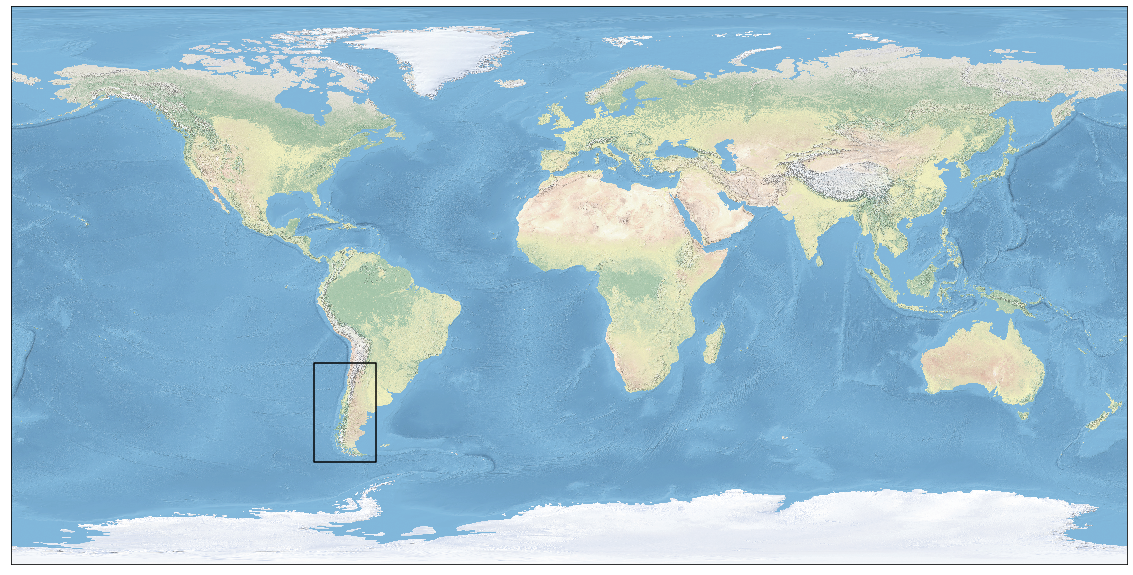

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

minx  miny  maxx  maxy
16 -82.0 -57.0 -62.0 -25.0

# * * * * * * * * Glacier Analysis * * * * * * * *

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

region_no         glac_id      area   db_area  width   length  primeclass  \
0         17  G286372E49263S  1343.930  1344.670    0.0  54182.8         0.0   
1         17  G286639E49733S   882.967   883.370    0.0  54338.8         0.0   
2         17  G286651E48942S   882.399   882.787    0.0  32290.4         0.0   
3         17  G286731E49384S   858.353   858.706    0.0  38376.7         0.0   
4         17  G286485E46923S   781.699   782.106    0.0  58998.8         0.0   

   min_elev  mean_elev  max_elev             src_date glac_name  \
0       0.0        0.0       0.0  2007-09-06T00:00:00      None   
1       0.0        0.0       0.0  2007-09-06T00:00:00      None   
2       0.0        0.0       0.0  2007-09-06T00:00:00      None   
3       0.0        0.0       0.0  2007-09-06T00:00:00      None   
4       0.0        0.0       0.0  2007-09-06T00:00:00      None   

                                            geometry  
0  POLYGON Z ((-73.49575299999999 -49.038599 0, -...  
1  POLYGON Z ((-73.123845 -49.659272 0, -73.12978...  
2  POLYGON Z ((-73.293724 -48.698177 0, -73.28181...  
3  POLYGON Z ((-73.07831 -49.466543 0, -73.078948...  
4  POLYGON Z ((-73.801663 -46.783449 0, -73.80203...

## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

In [12]:
rgi_glaciers_df

RGIId         GLIMSId   BgnDate   EndDate   CenLon   CenLat  \
0  RGI60-17.05181  G286375E49261S  20009999  20030531 -73.6248 -49.2613   
1  RGI60-17.05076  G286716E49359S  20009999  20030531 -73.2843 -49.3590   
2  RGI60-17.00172  G286530E49887S  20009999  20030531 -73.4697 -49.8866   
3  RGI60-17.15804  G286485E46923S  20011103  -9999999 -73.5150 -46.9230   
4  RGI60-17.05184  G286653E48907S  20009999  20030531 -73.3474 -48.9067   

  O1Region O2Region      Area  Zmin  ...  Aspect   Lmax  Status  Connect  \
0       17        1  1234.714     7  ...     285  70199       0        0   
1       17        1   975.276   275  ...     117  72067       0        0   
2       17        1   838.044   193  ...     133  59615       0        0   
3       17        1   790.282     9  ...     289  69043       0        0   
4       17        1   762.324   271  ...      98  40008       0        0   

   Form  TermType  Surging  Linkages           Name  \
0     1         1        3         9         Pio XI   
1     1         2        9         9         Viedma   
2     0         2        9         9  Upsala + Cono   
3     0         2        9         9    San Quintin   
4     1         2        9         9       OHiggins   

                                            geometry  
0  POLYGON ((-73.49967543099996 -49.0452341699999...  
1  POLYGON ((-73.45125545399998 -49.0764382959999...  
2  POLYGON ((-73.25087929999995 -49.5622459379999...  
3  POLYGON ((-73.70465999999993 -46.8900499999999...  
4  POLYGON ((-73.32595861499993 -48.6945666239999...  

[5 rows x 23 columns]

## Plot GLIMS Glaciers

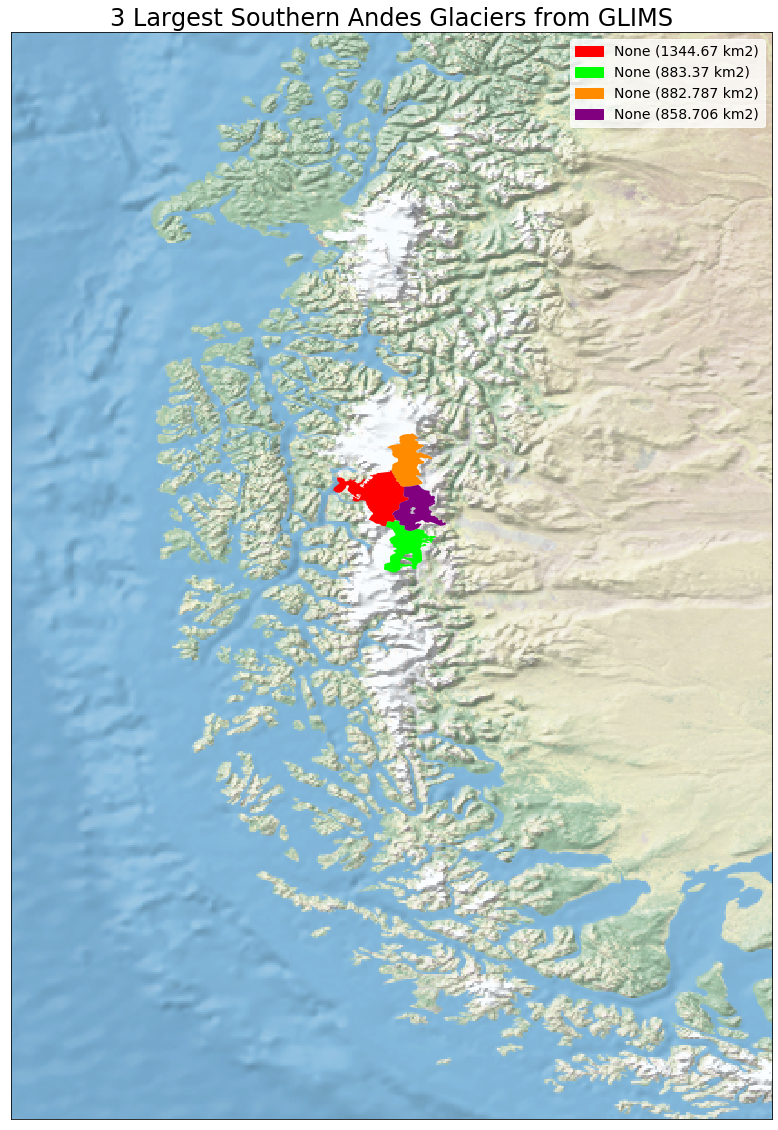

In [39]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange', 'purple']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)',
                 glims_glaciers_df['glac_name'][3] + ' (' + str(glims_glaciers_df['db_area'][3]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
#zoom in
minx = -77
maxx = -70
miny = -55
maxy = -45

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color=legend_colors[0])
glims_glaciers_df.iloc[1:2].plot(ax=ax, color=legend_colors[1])
glims_glaciers_df.iloc[2:3].plot(ax=ax, color=legend_colors[2])
glims_glaciers_df.iloc[3:4].plot(ax=ax, color=legend_colors[3])
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Plot RGI Glaciers

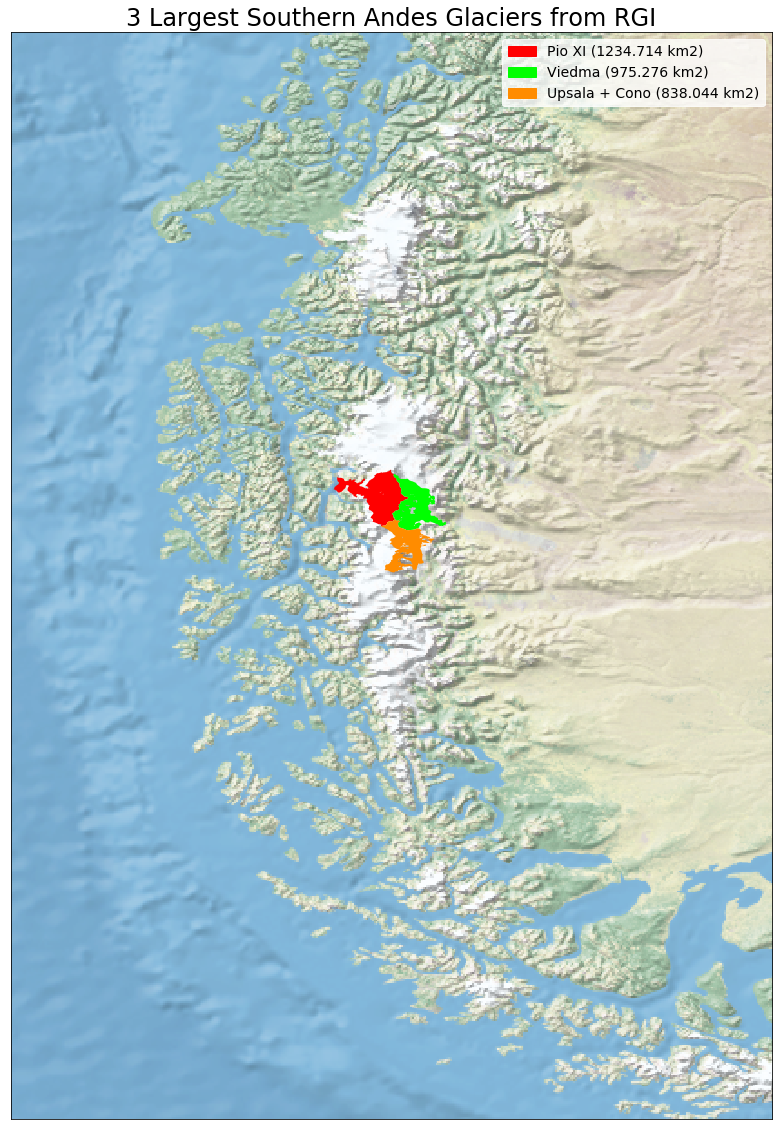

In [40]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
#zoom in
minx = -77
maxx = -70
miny = -55
maxy = -45
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate. Once the differences have been investigated and corrected in the code below this code block, set handled to 1 in the "Set Up Region Info" section at the top of the notebook, so that it passes this test.

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create Final Glacier Shapefiles
This section creates and formats the final glacier dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

* 1st largest matches between GLIMS and RGI: Pio XI Glacier
* 2nd largest of GLIMS matches 3rd largest of RGI (Upsala + Cono) I would just call this Upsala based on from Sakakibara (2014) and FoG WGMS
* 3rd largest of GLIMS matches RGI's 5th (I think this is O'Higgins from Sakakibara (2014) and FoG WGMS).
* 2nd largest of RGI matches the 4th largest of GLIMS (Viedma)

Since GLIMS is the latest data, going with the GLIMS top 3 glaciers.

### Create final glacier dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_glacier_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                                'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_glacier_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_glacier_data_df['primeclass'] = primeclass

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glac_id', 
                               'primeclass', 'db_area', 'src_date', 'geometry']]

# Rename some columns
final_glacier_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop last 2 rows because they are the fourth and fifthe largest glaciers and we aren't interested in them
final_glacier_data_df.drop([3, 4], inplace = True)

# Reset index
final_glacier_data_df = final_glacier_data_df.reset_index(drop=True)

In [17]:
final_glacier_data_df

region_no        reg_name glac_name        glims_id  primeclass  area_km2  \
0         17  Southern Andes      None  G286372E49263S           4  1344.670   
1         17  Southern Andes      None  G286639E49733S           4   883.370   
2         17  Southern Andes      None  G286651E48942S           4   882.787   

                  date                                           geometry  
0  2007-09-06T00:00:00  POLYGON Z ((-73.49575299999999 -49.038599 0, -...  
1  2007-09-06T00:00:00  POLYGON Z ((-73.123845 -49.659272 0, -73.12978...  
2  2007-09-06T00:00:00  POLYGON Z ((-73.293724 -48.698177 0, -73.28181...

In [18]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
for x in range(3):
    if x == 0: # GLIMS and RGI match on the 1st largest
        # Exract and clean GLIMS date so that it is comparable to RGI date
        glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
        glims_year = glims_date[0:4]
        print('glims date: ' + glims_date)
        #print('glims year: ' + glims_year)
    
        # Extract RGI date
        rgi_date = rgi_glaciers_df['BgnDate'][x]
        rgi_year = rgi_date[0:4]
        print('rgi date: ' + rgi_date)
        #print('rgi year: ' + rgi_year)
    
        if glims_year == rgi_year:
            # Average GLIMS and RGI areas
            area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x]])
            print('Averaging area: ' + str(area))
        elif glims_year > rgi_year:
            # Use GLIMS area for the area
            area = glims_glaciers_df['db_area'][x]
            print('Using GLIMS area: ' + str(area))
        elif rgi_year > glims_year:
            # Use RGI area for the area
            area = rgi_glaciers_df['Area'][x]
            print('Using RGI area: ' + str(area))
        else:
            print("Error. Area could not be calculated.")
    
        print('')
        # Set the area in the final dataframe
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    
        # Clean the date format in the final dataframe
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = \
        glims_glaciers_df['src_date'][x][0:10]
        
    if x == 1: # 2nd largest of GLIMS matches 3rd largest of RGI
        # Exract and clean GLIMS date so that it is comparable to RGI date
        glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
        glims_year = glims_date[0:4]
        print('glims date: ' + glims_date)
        #print('glims year: ' + glims_year)
    
        # Extract RGI date
        rgi_date = rgi_glaciers_df['BgnDate'][x+1]
        rgi_year = rgi_date[0:4]
        print('rgi date: ' + rgi_date)
        #print('rgi year: ' + rgi_year)
    
        if glims_year == rgi_year:
            # Average GLIMS and RGI areas
            area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x+1]])
            print('Averaging area: ' + str(area))
        elif glims_year > rgi_year:
            # Use GLIMS area for the area
            area = glims_glaciers_df['db_area'][x]
            print('Using GLIMS area: ' + str(area))
        elif rgi_year > glims_year:
            # Use RGI area for the area
            area = rgi_glaciers_df['Area'][x+1]
            print('Using RGI area: ' + str(area))
        else:
            print("Error. Area could not be calculated.")
    
        print('')
        # Set the area in the final dataframe
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    
        # Clean the date format in the final dataframe
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = \
        glims_glaciers_df['src_date'][x][0:10]
        
    if x == 2: # 3rd largest of GLIMS matches 5th of RGI
        # Exract and clean GLIMS date so that it is comparable to RGI date
        glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
        glims_year = glims_date[0:4]
        print('glims date: ' + glims_date)
        #print('glims year: ' + glims_year)
    
        # Extract RGI date
        rgi_date = rgi_glaciers_df['BgnDate'][x+2]
        rgi_year = rgi_date[0:4]
        print('rgi date: ' + rgi_date)
        #print('rgi year: ' + rgi_year)
    
        if glims_year == rgi_year:
            # Average GLIMS and RGI areas
            area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x+2]])
            print('Averaging area: ' + str(area))
        elif glims_year > rgi_year:
            # Use GLIMS area for the area
            area = glims_glaciers_df['db_area'][x]
            print('Using GLIMS area: ' + str(area))
        elif rgi_year > glims_year:
            # Use RGI area for the area
            area = rgi_glaciers_df['Area'][x+2]
            print('Using RGI area: ' + str(area))
        else:
            print("Error. Area could not be calculated.")
    
        print('')
        # Set the area in the final dataframe
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    
        # Clean the date format in the final dataframe
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = \
        glims_glaciers_df['src_date'][x][0:10]
    
# Clean up glacier names
final_glacier_data_df.iloc[0, final_glacier_data_df.columns.get_loc('glac_name')] = "Pio XI Glacier"
final_glacier_data_df.iloc[1, final_glacier_data_df.columns.get_loc('glac_name')] = "Upsala Glacier"
final_glacier_data_df.iloc[2, final_glacier_data_df.columns.get_loc('glac_name')] = "O'Higgins Glacier"

glims date: 20070906
rgi date: 20009999
Using GLIMS area: 1344.67

glims date: 20070906
rgi date: 20009999
Using GLIMS area: 883.37

glims date: 20070906
rgi date: 20009999
Using GLIMS area: 882.787



In [19]:
final_glacier_data_df

region_no        reg_name          glac_name        glims_id  primeclass  \
0         17  Southern Andes     Pio XI Glacier  G286372E49263S           4   
1         17  Southern Andes     Upsala Glacier  G286639E49733S           4   
2         17  Southern Andes  O'Higgins Glacier  G286651E48942S           4   

   area_km2        date                                           geometry  
0  1344.670  2007-09-06  POLYGON Z ((-73.49575299999999 -49.038599 0, -...  
1   883.370  2007-09-06  POLYGON Z ((-73.123845 -49.659272 0, -73.12978...  
2   882.787  2007-09-06  POLYGON Z ((-73.293724 -48.698177 0, -73.28181...

### Plot final glacier dataframe to check accuracy

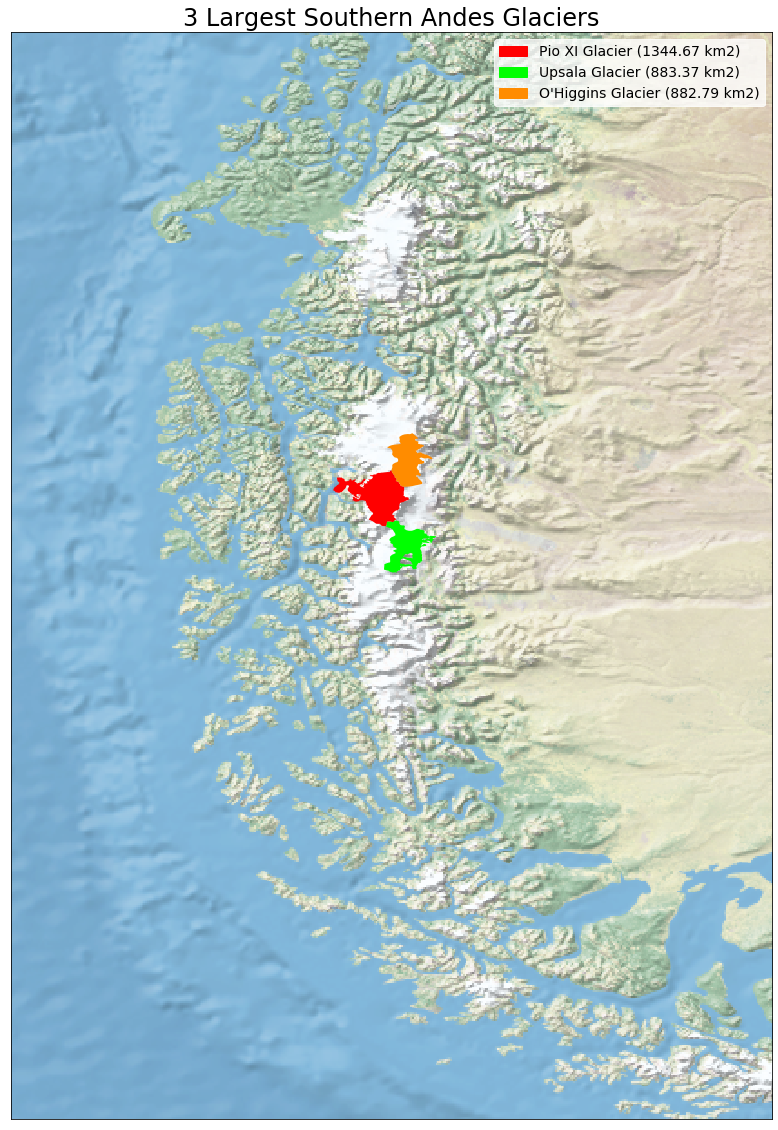

In [41]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_glacier_data_df['glac_name'][0] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][0], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][1] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][1], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][2] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
#zoom in
minx = -77
maxx = -70
miny = -55
maxy = -45
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_glacier_data_df.iloc[0:1].plot(ax=ax, color='red')
final_glacier_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_glacier_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create largest glacier shapefile from the final glacier dataframe

In [21]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
glacier_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(glacier_zipfile_fn) == False:
    # Create the shapefile
    final_glacier_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_glacier_data_df.to_file(driver='ESRI Shapefile', filename=final_glacier_data_fn)
    
    # Zip up the shapefile
    glacier_zipfile_fn = ws.zipshp(final_glacier_data_fn, Delete=True)
    print("Creating zipfile: " + glacier_zipfile_fn)
else:
    print(glacier_zipfile_fn + " already extists")

data/final-dataset/region-17-largest-glaciers.zip already extists


# * * * * * * * * Ice Cap Analysis * * * * * * * *

In [22]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                  region_number + "_esri" + ic_epsg + ".shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [23]:
ice_caps_ex_df

id          area                                           geometry
0  1218  13326.373878  POLYGON ((-73.437455 -51.432202, -73.438247289...
1  1133   4017.745915  POLYGON ((-73.38980132210779 -47.4761428547968...
2   225   1893.592809  (POLYGON ((-70.10073199999999 -54.740177, -70....
3   322    247.104651  POLYGON ((-72.547676 -53.863166, -72.547894 -5...
4   394    236.518499  POLYGON ((-72.99818827787728 -52.9660822092353...
5    57    230.958209  POLYGON ((-69.63212300000001 -55.229072, -69.6...
6   715    203.032959  POLYGON ((-72.377498 -48.552176, -72.377526 -4...
7   195    190.324433  POLYGON ((-70.455744 -54.594605, -70.455734000...
8  1298    150.570890  POLYGON ((-72.89802922208995 -45.9486449337997...
9  1161    150.359292  POLYGON ((-72.27105299999999 -47.590967, -72.2...

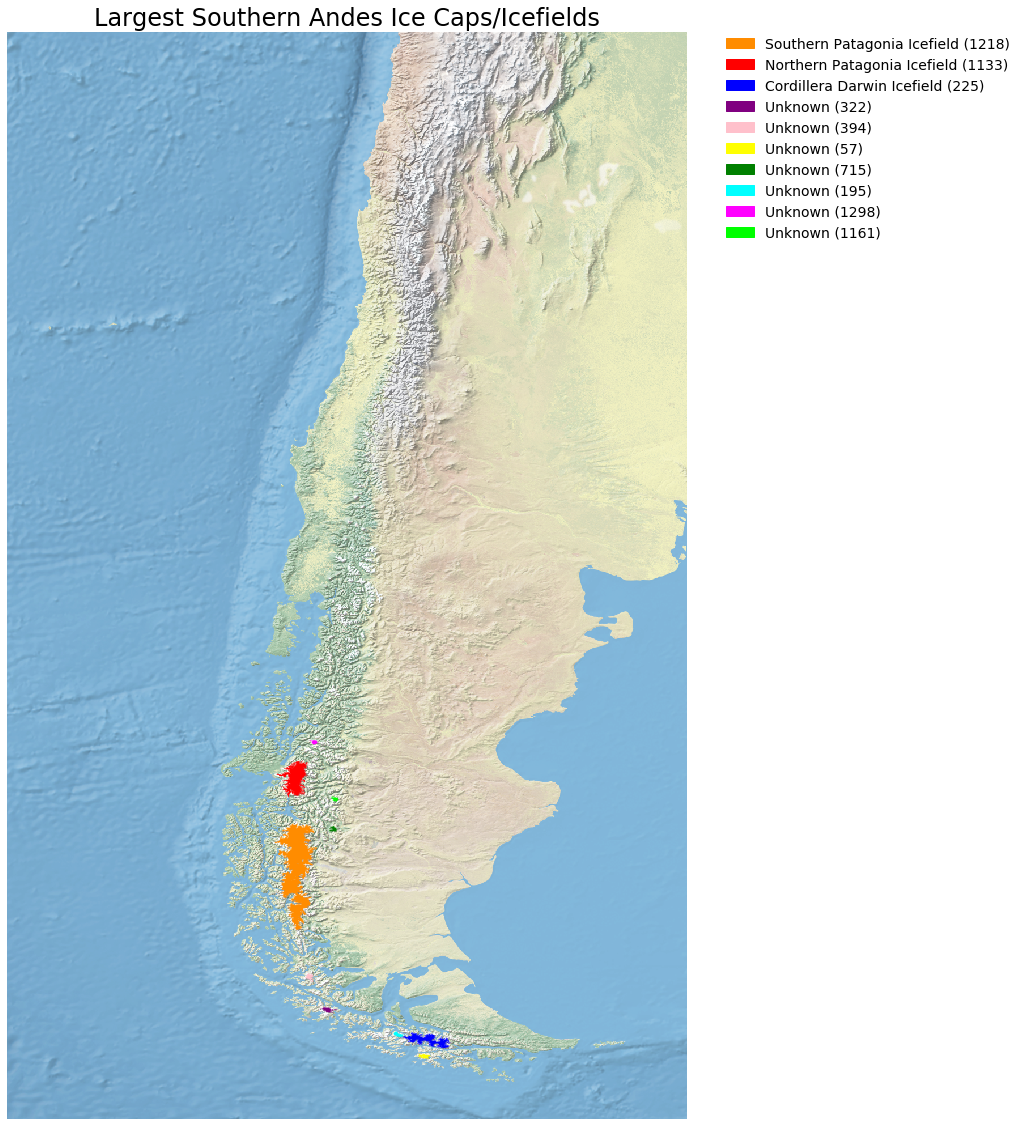

In [24]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = ['Southern Patagonia Icefield (1218)', 'Northern Patagonia Icefield (1133)', 
                 'Cordillera Darwin Icefield (225)', 
                 'Unknown (322)', 'Unknown (394)', 'Unknown (57)', 'Unknown (715)', 
                 'Unknown (195)', 'Unknown (1298)', 'Unknown (1161)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [25]:
# Stop notebook and examine ice caps and icefields. 
# Comment this out when not needed.
#class StopExecution(Exception):
#    def _render_traceback_(self):
#        pass

#print("Stopping notebook to examine glacier complexes.")
#raise StopExecution

## Create Final Ice Catchment Data Frame
This ice catchment data frame will then be saved to a shapefile.

In [26]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps and icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [2, 2, 2]

# Add catchment names
final_catchment_data_df['ic_name'] = ['Southern Patagonia Icefield', 'Northern Patagonia Icefield', 
                                      'Cordillera Darwin Icefield']

In [27]:
final_catchment_data_df

area                                           geometry region_no  \
0  13326.373878  POLYGON ((-73.437455 -51.432202, -73.438247289...        17   
1   4017.745915  POLYGON ((-73.38980132210779 -47.4761428547968...        17   
2   1893.592809  (POLYGON ((-70.10073199999999 -54.740177, -70....        17   

         reg_name  primeclass                      ic_name  
0  Southern Andes           2  Southern Patagonia Icefield  
1  Southern Andes           2  Northern Patagonia Icefield  
2  Southern Andes           2   Cordillera Darwin Icefield

### Get ice catchment measurement dates from a range of glacier outline dates.

In [28]:
# Open GLIMS shapefile with all of the glacier outlines
glims_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [29]:
# Buffer ice_caps_ex_df because it has some ill formed polygons
# I didn't have to do this for any other regions, haven't checked how buffereing changes the area
ice_caps_ex_df['geometry'] = ice_caps_ex_df.buffer(0)

# Get glaciers on Southern Patagonia Icefield
southern_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True))
southern_glaciers = glims_all_glaciers_df.loc[southern_ic_mask]

# Print the minimum date and the maximum date
southern_glaciers_min_date = southern_glaciers['src_date'].min()[0:10]
southern_glaciers_max_date = southern_glaciers['src_date'].max()[0:10]
print('southern start date: ' + southern_glaciers_min_date)
print('southern end date: ' + southern_glaciers_max_date)
print('')

# Get glaciers on Northern Patagonia Icefield
northern_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True))
northern_glaciers = glims_all_glaciers_df.loc[northern_ic_mask]

# Print the minimum date and the maximum date
northern_glaciers_min_date = northern_glaciers['src_date'].min()[0:10]
northern_glaciers_max_date = northern_glaciers['src_date'].max()[0:10]
print('northern start date: ' + northern_glaciers_min_date)
print('northern end date: ' + northern_glaciers_max_date)
print('')

# Get glaciers on Cordillera Darwin Icefield
darwin_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True))
darwin_glaciers = glims_all_glaciers_df.loc[darwin_ic_mask]

# Print the minimum date and the maximum date
darwin_glaciers_min_date = darwin_glaciers['src_date'].min()[0:10]
darwin_glaciers_max_date = darwin_glaciers['src_date'].max()[0:10]
print('darwin start date: ' + darwin_glaciers_min_date)
print('darwin end date: ' + darwin_glaciers_max_date)
print('')

southern start date: 2000-06-15
southern end date: 2007-09-06

northern start date: 2000-06-15
northern end date: 2007-09-06

darwin start date: 2000-06-15
darwin end date: 2007-09-06



In [30]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [southern_glaciers_min_date, northern_glaciers_min_date, darwin_glaciers_min_date]

final_catchment_data_df['max_date'] = [southern_glaciers_max_date, northern_glaciers_max_date, darwin_glaciers_max_date]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 'min_date', 
                                                   'max_date', 'geometry']]
# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [31]:
final_catchment_data_df

region_no        reg_name                      ic_name  primeclass  \
0        17  Southern Andes  Southern Patagonia Icefield           2   
1        17  Southern Andes  Northern Patagonia Icefield           2   
2        17  Southern Andes   Cordillera Darwin Icefield           2   

       area_km2    min_date    max_date  \
0  13326.373878  2000-06-15  2007-09-06   
1   4017.745915  2000-06-15  2007-09-06   
2   1893.592809  2000-06-15  2007-09-06   

                                            geometry  
0  POLYGON ((-73.437455 -51.432202, -73.438247289...  
1  POLYGON ((-73.38980132210779 -47.4761428547968...  
2  (POLYGON ((-70.10073199999999 -54.740177, -70....

### Plot the final catchment dataframe to verify it looks correct

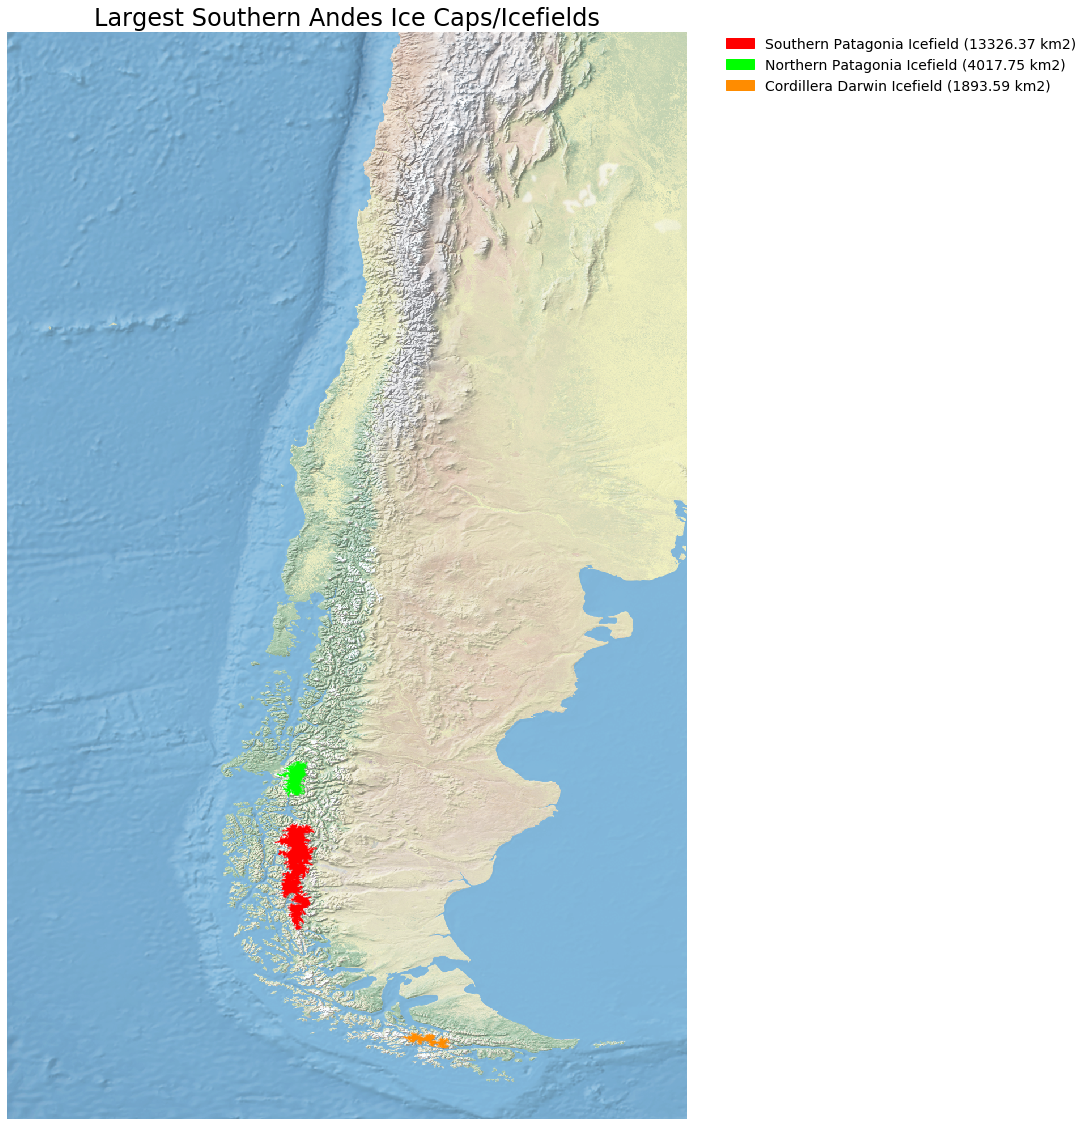

In [32]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="red")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="lime")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="darkorange")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [33]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

data/final-dataset/region-17-largest-complexes.zip already extists
